In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from flask import Flask, request, jsonify
from keras.optimizers import Adam
from gensim.models import Word2Vec
from nltk.stem import SnowballStemmer, WordNetLemmatizer

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Load the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
# Display the first few rows of the dataset
print(train_data.head())

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [5]:
# Get the summary statistics of the dataset
print(train_data.describe())

               toxic   severe_toxic        obscene         threat  \
count  159571.000000  159571.000000  159571.000000  159571.000000   
mean        0.095844       0.009996       0.052948       0.002996   
std         0.294379       0.099477       0.223931       0.054650   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

              insult  identity_hate  
count  159571.000000  159571.000000  
mean        0.049364       0.008805  
std         0.216627       0.093420  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000  


In [6]:
# Check the data types and missing values
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None


In [7]:
# Analyze the distribution of each toxicity class
toxicity_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [8]:
# Count the number of comments for each toxicity class
toxicity_counts = train_data[toxicity_classes].sum()

In [9]:
# Display the counts of each toxicity class
print("Distribution of each toxicity class:")
print(toxicity_counts)

Distribution of each toxicity class:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [10]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# Preprocess the text data
def preprocess_text(text):
    # Remove URLs using regular expression
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # Convert text to lowercase
    text = text.lower()

    # Remove non-alphanumeric characters and keep only letters and numbers
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)

    # Perform stemming using Snowball stemmer
    stemmer = SnowballStemmer("english")
    words = text.split()
    words = [stemmer.stem(word) for word in words]

    # Perform lemmatization using WordNet lemmatizer
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Handle specific cases where lemmatization might cause issues
    words = [word if word != "ca" else "can" for word in words]
    words = [word if word != "wo" else "will" for word in words]

    # Join the processed words back to form the preprocessed text
    text = ' '.join(words)

    return text

# Apply preprocessing to the text data in the train dataset
train_data['processed_text'] = train_data['comment_text'].apply(preprocess_text)

# Display the first few rows of the processed dataset
print(train_data.head())

# Analyze the distribution of each toxicity class after preprocessing
toxicity_counts = train_data[toxicity_classes].sum()
print("Distribution of each toxicity class after preprocessing:")
print(toxicity_counts)

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  \
0             0        0       0       0              0   
1             0        0       0       0              0   
2             0        0       0       0              0   
3             0        0       0       0              0   
4             0        0       0       0              0   

                                      processed_text  
0  explan edit made usernam hardcor metallica fan...  
1  aww match background colour seem stuck thank 

In [12]:
# Display the first few rows of the processed dataset
print(train_data.head())

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  \
0             0        0       0       0              0   
1             0        0       0       0              0   
2             0        0       0       0              0   
3             0        0       0       0              0   
4             0        0       0       0              0   

                                      processed_text  
0  explan edit made usernam hardcor metallica fan...  
1  aww match background colour seem stuck thank 

In [13]:
# Analyze the distribution of each toxicity class after preprocessing
toxicity_counts = train_data[toxicity_classes].sum()
print("Distribution of each toxicity class after preprocessing:")
print(toxicity_counts)

Distribution of each toxicity class after preprocessing:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [14]:
# Split the data into training and testing sets
X = train_data['processed_text']
y = train_data[toxicity_classes]

In [15]:
# Split the data using train_test_split
# We will use 80% of the data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the training and testing sets
print("Training set shape - X_train:", X_train.shape, "y_train:", y_train.shape)
print("Testing set shape - X_test:", X_test.shape, "y_test:", y_test.shape)

Training set shape - X_train: (127656,) y_train: (127656, 6)
Testing set shape - X_test: (31915,) y_test: (31915, 6)


In [16]:
# Method 1: Bag-of-Words
vectorizer_bow = CountVectorizer(max_features=500)
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

In [17]:
# Method 2: TF-IDF
vectorizer_tfidf = TfidfVectorizer(max_features=500)  
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

In [63]:
# Preprocess text data for Word2Vec (tokenize sentences)
sentences = [sentence.split() for sentence in X_train]
sentences_test = [sentence.split() for sentence in X_test]

# Create and train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Generate Word2Vec embeddings for training set
X_train_word2vec = []
for sentence in sentences:
    embeddings = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    if embeddings:
        sentence_embedding = np.mean(embeddings, axis=0)
        X_train_word2vec.append(sentence_embedding)
    else:
        # If no word in the sentence has a vector representation, we can use a default vector or skip the sentence.
        # For simplicity, we'll use a zero vector.
        X_train_word2vec.append(np.zeros(word2vec_model.vector_size))

X_train_word2vec = np.array(X_train_word2vec)

# Generate Word2Vec embeddings for testing set
X_test_word2vec = []
for sentence in sentences_test:
    embeddings = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    if embeddings:
        sentence_embedding = np.mean(embeddings, axis=0)
        X_test_word2vec.append(sentence_embedding)
    else:
        X_test_word2vec.append(np.zeros(word2vec_model.vector_size))

X_test_word2vec = np.array(X_test_word2vec)

In [64]:
# Display the shapes of the extracted features
print("Bag-of-Words - X_train:", X_train_bow.shape, "X_test:", X_test_bow.shape)
print("TF-IDF - X_train:", X_train_tfidf.shape, "X_test:", X_test_tfidf.shape)
print("Word2Vec - X_train:", len(X_train_word2vec), "X_test:", len(X_test_word2vec))

Bag-of-Words - X_train: (127656, 500) X_test: (31915, 500)
TF-IDF - X_train: (127656, 500) X_test: (31915, 500)
Word2Vec - X_train: 127656 X_test: 31915


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Neural Networks - Feedforward Neural Network
# Build the Neural Network
model_nn = Sequential()
model_nn.add(Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dense(len(toxicity_classes), activation='sigmoid'))

# Compile the model
model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the TF-IDF features
model_nn.fit(X_train_tfidf.toarray(), np.array(y_train), epochs=5, batch_size=16, verbose=1)

# Predict on the test set
y_pred_nn = model_nn.predict(X_test_tfidf.toarray())
y_pred_nn[y_pred_nn >= 0.5] = 1
y_pred_nn[y_pred_nn < 0.5] = 0

# Evaluate the performance of the model
print("\nFeedforward Neural Network:")
print("Accuracy:", accuracy_score(y_test, y_pred_nn))
print("F1-Score:", f1_score(y_test, y_pred_nn, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred_nn, target_names=toxicity_classes))

Epoch 1/5
7979/7979 [==============================] - 75s 9ms/step - loss: 0.0800 - accuracy: 0.9798
Epoch 2/5
7979/7979 [==============================] - 74s 9ms/step - loss: 0.0720 - accuracy: 0.9776
Epoch 3/5
7979/7979 [==============================] - 73s 9ms/step - loss: 0.0695 - accuracy: 0.9822
Epoch 4/5
7979/7979 [==============================] - 76s 9ms/step - loss: 0.0671 - accuracy: 0.9753
Epoch 5/5
998/998 [==============================] - 8s 7ms/step

Feedforward Neural Network:
Accuracy: 0.9102616324612252
F1-Score: 0.5858825214609898
Classification Report:
                precision    recall  f1-score   support

        toxic       0.86      0.47      0.61      3056
 severe_toxic       0.54      0.16      0.25       321
      obscene       0.89      0.58      0.71      1715
       threat       0.50      0.14      0.21        74
       insult       0.76      0.44      0.56      1614
identity_hate       0.72      0.20      0.31       294

    micro avg       0.83     

C:\Users\KIIT\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KIIT\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.optimizers import Adam
from sklearn.ensemble import StackingClassifier
from gensim.models import Word2Vec

# Deep learning model - LSTM
# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=10000, output_dim=128, input_length=X_train_tfidf.shape[1]))
model_lstm.add(LSTM(128))
model_lstm.add(Dense(len(toxicity_classes), activation='sigmoid'))

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the TF-IDF features
model_lstm.fit(X_train_tfidf.toarray(), np.array(y_train), epochs=5, batch_size=16, verbose=1)

# Predict on the test set
y_pred_lstm = model_lstm.predict(X_test_tfidf.toarray())
y_pred_lstm[y_pred_lstm >= 0.5] = 1
y_pred_lstm[y_pred_lstm < 0.5] = 0

# Evaluate the performance of the model
print("\nLSTM:")
print("Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("F1-Score:", f1_score(y_test, y_pred_lstm, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred_lstm, target_names=toxicity_classes))

Epoch 1/5
7979/7979 [==============================] - 8059s 1s/step - loss: 0.1422 - accuracy: 0.9924
Epoch 2/5
7979/7979 [==============================] - 11895s 1s/step - loss: 0.1413 - accuracy: 0.9942
Epoch 3/5
1616/7979 [=====>........................] - ETA: 2:21:07 - loss: 0.1426 - accuracy: 0.9942

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Problem Transformation Method - MultiOutputClassifier with RandomForestClassifier
# Build the Random Forest Classifier
classifier_rf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))

# Train the model on the TF-IDF features
classifier_rf.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_rf = classifier_rf.predict(X_test_tfidf)

# Evaluate the performance of the model
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1-Score:", f1_score(y_test, y_pred_rf, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred_rf, target_names=toxicity_classes))

Random Forest Classifier:
Accuracy: 0.9096036346545512
F1-Score: 0.5817766819505579
Classification Report:
                precision    recall  f1-score   support

        toxic       0.86      0.47      0.61      3056
 severe_toxic       0.53      0.13      0.21       321
      obscene       0.86      0.61      0.71      1715
       threat       0.38      0.07      0.11        74
       insult       0.73      0.45      0.56      1614
identity_hate       0.65      0.15      0.24       294

    micro avg       0.82      0.46      0.59      7074
    macro avg       0.67      0.31      0.41      7074
 weighted avg       0.80      0.46      0.58      7074
  samples avg       0.04      0.04      0.04      7074



C:\Users\KIIT\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KIIT\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Adapted Algorithm (Binary Relevance with Naive Bayes)
# Build the Naive Bayes classifier
classifier_nb = MultinomialNB()

# Using Classifier Chain for Binary Relevance
classifier_chain = ClassifierChain(classifier_nb)

# Train the model on the TF-IDF features
classifier_chain.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_nb = classifier_chain.predict(X_test_tfidf)

# Evaluate the performance of the model
print("Binary Relevance with Naive Bayes:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("F1-Score:", f1_score(y_test, y_pred_nb, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred_nb, target_names=toxicity_classes))

Binary Relevance with Naive Bayes:
Accuracy: 0.8993576688077707
F1-Score: 0.552048540294577
Classification Report:
                precision    recall  f1-score   support

        toxic       0.96      0.37      0.53      3056
 severe_toxic       0.34      0.57      0.43       321
      obscene       0.84      0.56      0.67      1715
       threat       0.04      0.30      0.07        74
       insult       0.69      0.49      0.57      1614
identity_hate       0.14      0.54      0.23       294

    micro avg       0.57      0.46      0.51      7074
    macro avg       0.50      0.47      0.42      7074
 weighted avg       0.80      0.46      0.55      7074
  samples avg       0.02      0.03      0.03      7074



C:\Users\KIIT\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KIIT\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Ensemble Algorithm - MultiOutputClassifier with Logistic Regression
# Create a MultiOutputClassifier with Logistic Regression as the base classifier
classifier_lr = MultiOutputClassifier(LogisticRegression())

# Train the model on the TF-IDF features
classifier_lr.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_lr = classifier_lr.predict(X_test_tfidf)

# Evaluate the performance of the model
print("Ensemble Algorithm - MultiOutputClassifier with Logistic Regression :")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-Score:", f1_score(y_test, y_pred_lr, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred_lr, target_names=toxicity_classes))

Ensemble Algorithm - Logistic Regression:
Accuracy: 0.9107942973523422
F1-Score: 0.5727012832796251
Classification Report:
                precision    recall  f1-score   support

        toxic       0.88      0.45      0.60      3056
 severe_toxic       0.56      0.18      0.28       321
      obscene       0.91      0.56      0.69      1715
       threat       0.57      0.11      0.18        74
       insult       0.78      0.40      0.53      1614
identity_hate       0.74      0.17      0.27       294

    micro avg       0.85      0.44      0.58      7074
    macro avg       0.74      0.31      0.43      7074
 weighted avg       0.84      0.44      0.57      7074
  samples avg       0.04      0.04      0.04      7074



C:\Users\KIIT\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KIIT\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
#Concluding :-

In [48]:
# Problem Transformation Method - MultiOutputClassifier with RandomForestClassifier
print("Problem Transformation Method - MultiOutputClassifier with RandomForestClassifier :")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1-Score:", f1_score(y_test, y_pred_rf, average='weighted'))

# Ensemble Algorithm - MultiOutputClassifier with Logistic Regression 
print("Ensemble Algorithm - MultiOutputClassifier with Logistic Regression :")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-Score:", f1_score(y_test, y_pred_lr, average='weighted'))

# Adapted Algorithm (Binary Relevance with Naive Bayes)
print("Adapted Algorithm (Binary Relevance with Naive Bayes) :")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("F1-Score:", f1_score(y_test, y_pred_nb, average='weighted'))

# Neural Networks - Feedforward Neural Network
print("Neural Networks - Feedforward Neural Network :")
print("Accuracy:", accuracy_score(y_test, y_pred_nn))
print("F1-Score:", f1_score(y_test, y_pred_nn, average='weighted'))

# Deep learning model - LSTM
print("Deep learning model - LSTM :")
print("Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("F1-Score:", f1_score(y_test, y_pred_lstm, average='weighted'))

Problem Transformation Method - MultiOutputClassifier with RandomForestClassifier :
Accuracy: 0.9096036346545512
F1-Score: 0.5817766819505579
Ensemble Algorithm - MultiOutputClassifier with Logistic Regression :
Accuracy: 0.9107942973523422
F1-Score: 0.5727012832796251
Adapted Algorithm (Binary Relevance with Naive Bayes) :
Accuracy: 0.8993576688077707
F1-Score: 0.552048540294577
Neural Networks - Feedforward Neural Network :
Accuracy: 0.9102616324612252
F1-Score: 0.5858825214609898
Deep learning model - LSTM :
Accuracy: 0.898355005483315
F1-Score: 0.0


In [60]:
#The best model is Logistic Regression

C:\Users\KIIT\AppData\Local\Temp\ipykernel_5904\821455546.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


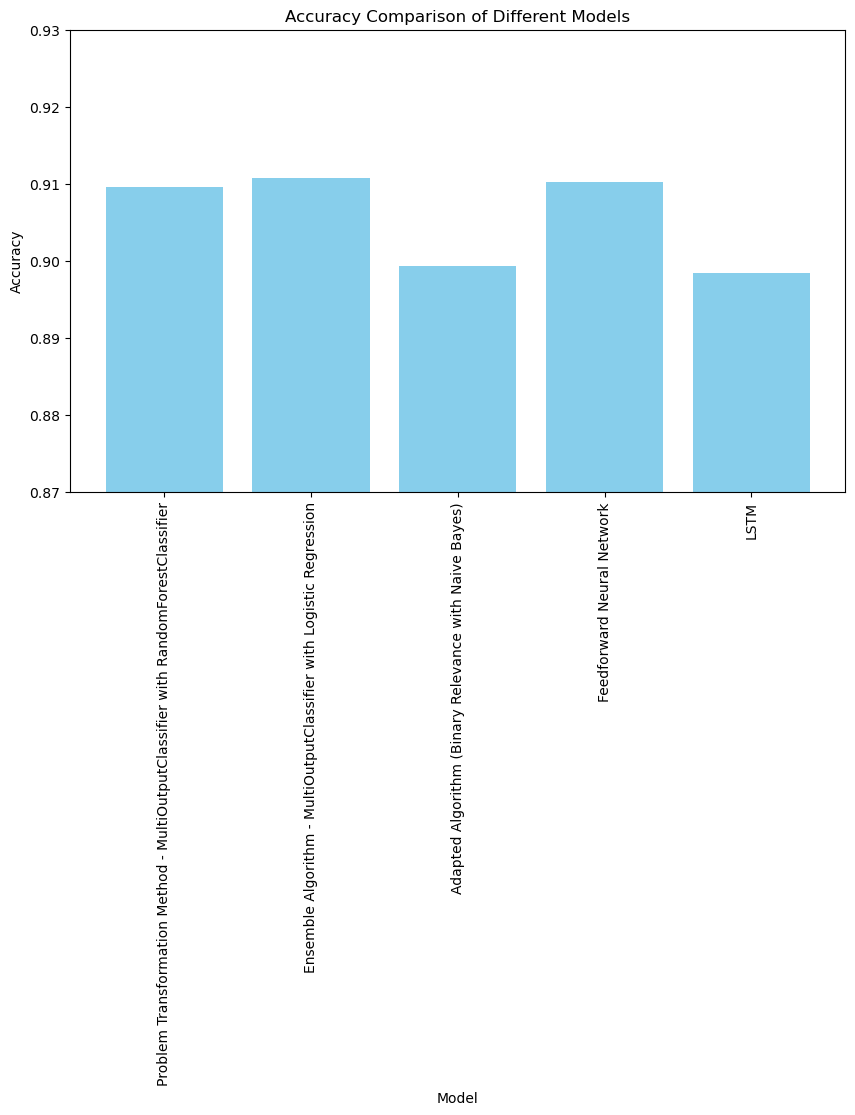

C:\Users\KIIT\AppData\Local\Temp\ipykernel_5904\821455546.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


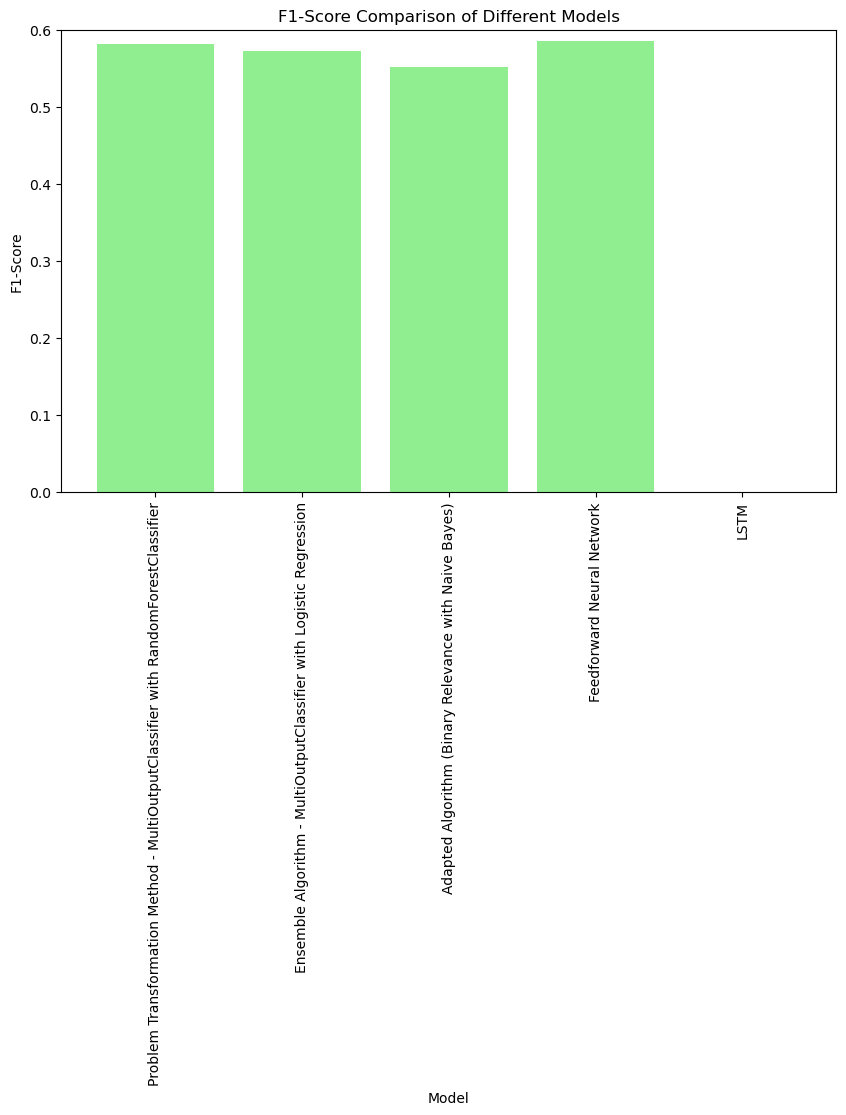

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.optimizers import Adam
from sklearn.ensemble import StackingClassifier

models = ['Problem Transformation Method - MultiOutputClassifier with RandomForestClassifier', 'Ensemble Algorithm - MultiOutputClassifier with Logistic Regression', 'Adapted Algorithm (Binary Relevance with Naive Bayes)' , 'Feedforward Neural Network', 'LSTM']
accuracies = []
f1_scores = []

# Append accuracy and F1-score of each model
accuracies.append(accuracy_score(y_test, y_pred_rf))
accuracies.append(accuracy_score(y_test, y_pred_lr))
accuracies.append(accuracy_score(y_test, y_pred_nb))
accuracies.append(accuracy_score(y_test, y_pred_nn))
accuracies.append(accuracy_score(y_test, y_pred_lstm))

f1_scores.append(f1_score(y_test, y_pred_rf, average='weighted'))
f1_scores.append(f1_score(y_test, y_pred_lr, average='weighted'))
f1_scores.append(f1_score(y_test, y_pred_nb, average='weighted'))
f1_scores.append(f1_score(y_test, y_pred_nn, average='weighted'))
f1_scores.append(f1_score(y_test, y_pred_lstm, average='weighted'))

# Plot bar graphs to compare accuracy and F1-score of each model
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')
plt.title('Accuracy Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.87, 0.93)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color='lightgreen')
plt.title('F1-Score Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.ylim(0.0, 0.6)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()